# Functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [4]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
    BS = loadmat('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_exp\\calibration\\20200219oled_calibration\\oled_boundary_set'
                 , squeeze_me=True)
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
    BS = loadmat('C:\\Users\\llinc\\GitHub\\retina_exp\\calibration\\20200219oled_calibration\\oled_boundary_set'
                 , squeeze_me=True)
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb


In [5]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [6]:
def R_el(a,b,o):
    return a*b/np.sqrt(a**2*np.sin(o)**2+ b**2*np.cos(o)**2)

In [7]:
def DivCovState(sti, cellpos, Dis = 2):
    #number state = 2^5
    state = 0
    for DisFromCell in np.arange(-Dis,Dis+1):
        if cellpos+DisFromCell<0 or cellpos+DisFromCell>=len(sti): continue
        if sti[cellpos+DisFromCell] > 0:
            state += 2**(Dis+DisFromCell)
    return state

# Main

In [8]:
figmap = [[np.nan, 7,15,23,31,39,47,np.nan],
          [     1, 8,16,24,32,40,48,    55],
          [     2, 9,17,25,33,41,49,    56],
          [     3,10,18,26,34,42,50,    57],
          [     4,11,19,27,35,43,51,    58],
          [     5,12,20,28,36,44,52,    59],
          [     6,13,21,29,37,45,53,    60],
          [np.nan,14,22,30,38,46,54,np.nan]]
figmap = np.array(figmap)

In [9]:
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210504\\'
ensure_dir(exp_folder+'MI')
ensure_dir(exp_folder+'MI\\Fig')

In [10]:
annots = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties'
                 , squeeze_me=True)
RFP = annots['RF_properties']

In [11]:
filenames = ['merge_0315_conv_on_0.1_RL_6.5mW',
            'merge_0315_conv_off_0.1_RL_6.5mW',
            'merge_0315_div_on_0.1_RL_6.5mW',
            'merge_0315_div_off_0.1_RL_6.5mW']
dt = 1/60
for filename in filenames:
    annots = loadmat(exp_folder+'merge\\'+filename, squeeze_me =True)
    sti = annots['bin_pos']
    dt = 1./60.
    T=np.arange(len(sti))*dt+dt

    MIfig, MIax = plt.subplots(nrows=8, ncols=8)
    Information_cell = [0]*60
    for channelnumber in np.arange(1,61):
        rstate, _ = np.histogram(annots['reconstruct_spikes'][channelnumber-1], np.append(0,T))
        if sum(rstate)/len(rstate)/dt <= 0.3 or not (RFP[channelnumber-1]['Amplitude']>0.1): continue
        
        hRFsize = R_el(RFP[channelnumber-1]['X_Width'], RFP[channelnumber-1]['Y_Width'] ,RFP[channelnumber-1]['Angle'] )/BS['micro_per_pixel']
        cellpos = (RFP[channelnumber-1]['X_Coor']-BS['leftx_bar'])
        
        xstate = np.array([DivCovState(substi[::5], int(cellpos/5)) for substi in sti])

        window = [-1,1] # second
        timeshift, Information = PIfunc(rstate, xstate, np.ones_like(xstate), dt, window)
        Information_cell[channelnumber-1] = Information.copy()
        if max(Information[('Beer','UIx')]) < 0.05: continue

        MIax[np.where(figmap == channelnumber)][0].plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')])
        MIax[np.where(figmap == channelnumber)][0].set_title(str(channelnumber))
        MIax[np.where(figmap == channelnumber)][0].grid()

    MIfig.set_size_inches(60, 30)
    MIfig.savefig(exp_folder+'MI\\Fig\\MI_'+filename+'.tif', bbox_inches = 'tight',pad_inches = 0.3)
    plt.close(MIfig)
    np.savez(exp_folder+'MI\\MI_'+filename+'.npz', Information_cell = Information_cell, timeshift = timeshift)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

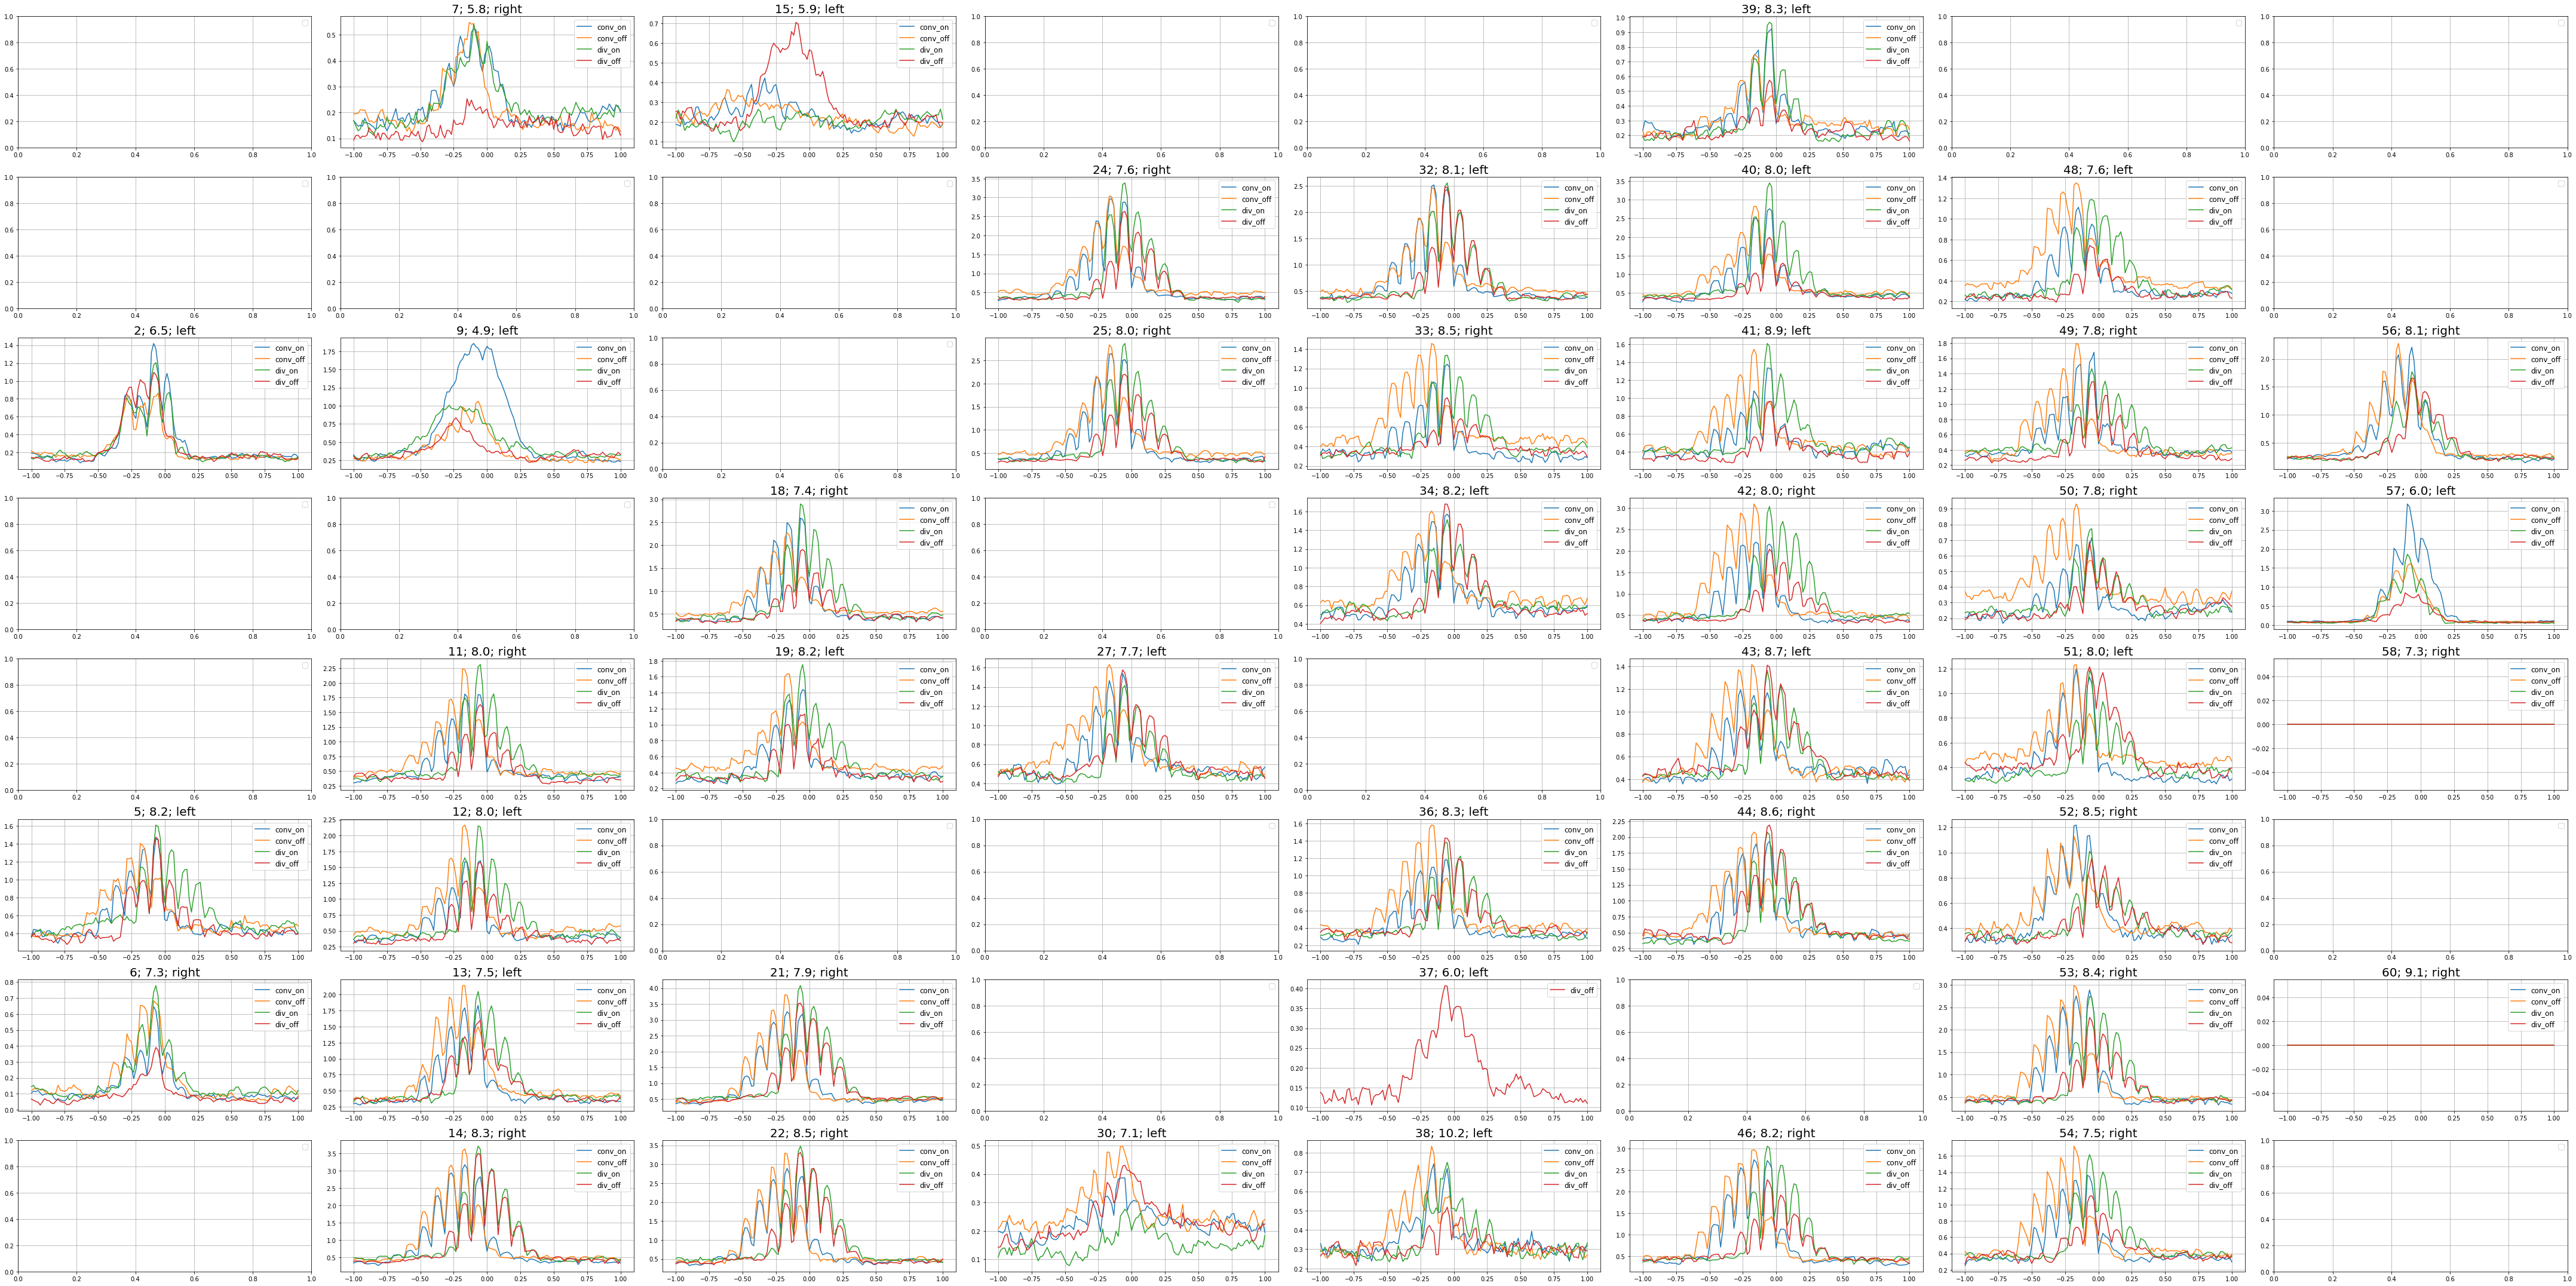

In [12]:
filenames = ['conv_on',
            'conv_off',
            'div_on',
            'div_off']


MIdFcfig, MIdFcax = plt.subplots(nrows=8, ncols=8)
cmind = 0
for filename in filenames:
    loadfiles = np.load(exp_folder+'MI\\MI_'+'merge_0315_'+filename+'_0.1_RL_6.5mW'+'.npz', allow_pickle=True)
    
    for k in loadfiles.files:
        vars()[k] = loadfiles[k][()]
        
    for cn in range(60):
        hRFsize = R_el(RFP[cn]['X_Width'], RFP[cn]['Y_Width'] ,RFP[cn]['Angle'] )/BS['micro_per_pixel']
        cellpos = (RFP[cn]['X_Coor']-BS['leftx_bar'])
        if cellpos%5<2.5:
            cellatbars = 'left'
        else:
            cellatbars = 'right'
        
        Information = Information_cell[cn]
        if Information == 0: continue
        MIdFcax[np.where(figmap == cn+1)][0].plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')]
                                                         , label=filename, color = plt.cm.tab10(cmind))
        MIdFcax[np.where(figmap == cn+1)][0].set_title(str(cn+1)+'; '+str(round(hRFsize/5, 1))+'; '+cellatbars, fontsize = 20)
#         MIdFcax[np.where(figmap == cn+1)][0].set_xlabel(r'$\delta t$ (s)', fontsize = 16)
#         MIdFcax[np.where(figmap == cn+1)][0].set_ylabel(r'Information (bit/s)', fontsize = 16)
    cmind += 1
    
for ax1d in MIdFcax:
    for ax in ax1d:
        ax.legend(fontsize = 12)
        ax.grid()
MIdFcfig.set_size_inches(60, 30)
MIdFcfig.tight_layout()
MIdFcfig.savefig(exp_folder+'MI\\Fig\\DivConv.tif', bbox_inches = 'tight',pad_inches = 0.3)